<h1>Insider Trading Python Framework</h1>
<p>The theory is that you can predict movements in stock price based on insider sentiment. These seems to be supported by several papers, which are included in the repo.</p>

<h2>Interacting with the database</h2>
<p>Here are a few commands that should help when you need to interface with the database.<br>
* Open the insider_trading database - psql insider_trading<br>
* List all tables - \dt<br>
* Delete everything from insides table - TRUNCATE * FROM insiders;<br><br>
    
Note that the database must be set up such that it will cause a conflict on reingestion of data that has already been consumed.
</p>


<h2>Global Variables</h2>
<p>These will be important to the entire script</p>

In [23]:
import yaml

def loadyaml(filename):
    with open(filename, "r") as yamlfile:
        try:
            return yaml.safe_load(yamlfile)
        except yaml.YAMLErorr as err:
            print(err)   

stocks = loadyaml("sandp10.yaml")
settings = loadyaml("settings.yaml")

print("Stocks struct looks like: " + stocks)
print("Settings struct looks like: " + settings)

TypeError: can only concatenate str (not "dict") to str

<h2>Webscraping</h2>
<p>This section will load insider trading statistics into the insider_trading database table insiders. We will also collect trading volume and stock price information in this section.</p>

In [22]:
from tqdm import tqdm
import os
import requests
from bs4 import BeautifulSoup
import psycopg        
            
def fetch_insider_trading(stocks, end_date, connection):
    
    def to_soup(url):
        url_response = requests.get(url)
        webpage = url_response.content
        soup = BeautifulSoup(webpage, 'html.parser')
        return soup

    def append_insider_data(single_insider, connection, company):
        try:
            cursor = connection.cursor()
            postgres_insert_query = """INSERT INTO insiders (
                                            acquistion_or_disposition, 
                                            transaction_date, 
                                            deemed_execution_date, 
                                            reporting_owner, form, 
                                            transaction_type, 
                                            direct_or_indirect_ownership, 
                                            number_of_securities_transacted, 
                                            number_of_securities_owned, 
                                            line_number, 
                                            owner_cik, 
                                            security_name, 
                                            company) 
                                        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
                                        ON CONFLICT DO NOTHING"""
            record_to_insert = (single_insider[0],
                                single_insider[1],
                                single_insider[2],
                                single_insider[3],
                                single_insider[4],
                                single_insider[5],
                                single_insider[6],
                                single_insider[7],
                                single_insider[8],
                                single_insider[9],
                                single_insider[10],
                                single_insider[11],
                                company)
            cursor.execute(postgres_insert_query, record_to_insert)
            connection.commit()
            cursor.close()
        except Exception as e:
            print(e)
    
    # TODO: Need to insert if statement for whether watch is marked true.
    with tqdm(total = len(stocks)) as progress_bar:
        for stock in stocks:
            try:
                page = 0
                urls = ['https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK='+str(stocks[stock].get("cik"))+'&type=&dateb=&owner=include&start='+str(page*80)]
                for url in urls:
                    print("fetching data from " + url)
                    soup = to_soup(url)
                    transaction_report = soup.find('table', {'id':'transaction-report'})

                    t_chil = [i for i in transaction_report.children]
                    t_cont = [i for i in t_chil if i != '\n']

                    data_rough = [i for lst in t_cont[1:] for i in lst.get_text().split('\n') if i != '' ]
                    data = [data_rough[i:i+12] for i in range(0,len(data_rough), 12)]
                    last_line = data[-1]
                    for row in data:
                        if (end_date > row[1]):
                            break
                        else:
                            if (row != last_line):
                                append_insider_data(row, connection, stocks[stock].get("symbol"))
                            else:
                                page += 1
                                urls.append('https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK='+str(stocks[stock].get("cik"))+'&type=&dateb=&owner=include&start='+str(page*80))
                os.system('cls' if os.name=='nt' else 'clear')
                progress_bar.update(1)
            except:
                print("failed to find " + stocks[stock].get("name") + " resource")
                os.system('cls' if os.name=='nt' else 'clear')
                progress_bar.update(1)
    connection.close()
            
if __name__ == "__main__":
    connection = psycopg.connect(user="ethan", password="ethan", host="127.0.0.1", port="5432", dbname="insider_trading")
    
    fetch_insider_trading(stocks, str(settings.get("start date")), connection)
    

  0%|                                                    | 0/10 [00:00<?, ?it/s]

fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=320193&type=&dateb=&owner=include&start=0
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=320193&type=&dateb=&owner=include&start=80
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=320193&type=&dateb=&owner=include&start=160
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=320193&type=&dateb=&owner=include&start=240
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=320193&type=&dateb=&owner=include&start=320
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=320193&type=&dateb=&owner=include&start=400
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=320193&type=&dateb=&owner=include&start=480
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=320193&type=&dateb=&owner=include&start=560
fetching data from https://www.sec.

 10%|████▍                                       | 1/10 [00:34<05:07, 34.15s/it]

fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=789019&type=&dateb=&owner=include&start=0
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=789019&type=&dateb=&owner=include&start=80
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=789019&type=&dateb=&owner=include&start=160
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=789019&type=&dateb=&owner=include&start=240
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=789019&type=&dateb=&owner=include&start=320
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=789019&type=&dateb=&owner=include&start=400
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=789019&type=&dateb=&owner=include&start=480
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=789019&type=&dateb=&owner=include&start=560
fetching data from https://www.sec.

 20%|████████▊                                   | 2/10 [01:09<04:39, 34.98s/it]

fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1018724&type=&dateb=&owner=include&start=0
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1018724&type=&dateb=&owner=include&start=80
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1018724&type=&dateb=&owner=include&start=160
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1018724&type=&dateb=&owner=include&start=240
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1018724&type=&dateb=&owner=include&start=320
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1018724&type=&dateb=&owner=include&start=400
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1018724&type=&dateb=&owner=include&start=480
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1018724&type=&dateb=&owner=include&start=560
fetching data from https://

fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1018724&type=&dateb=&owner=include&start=5360
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1018724&type=&dateb=&owner=include&start=5440
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1018724&type=&dateb=&owner=include&start=5520
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1018724&type=&dateb=&owner=include&start=5600


 30%|█████████████▏                              | 3/10 [02:31<06:33, 56.18s/it]

fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1318605&type=&dateb=&owner=include&start=0
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1318605&type=&dateb=&owner=include&start=80
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1318605&type=&dateb=&owner=include&start=160
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1318605&type=&dateb=&owner=include&start=240
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1318605&type=&dateb=&owner=include&start=320
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1318605&type=&dateb=&owner=include&start=400
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1318605&type=&dateb=&owner=include&start=480
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1318605&type=&dateb=&owner=include&start=560
fetching data from https://

 40%|█████████████████▌                          | 4/10 [03:18<05:15, 52.54s/it]

fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=0
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=80
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=160
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=240
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=320
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=400
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=480
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=560
fetching data from https://

fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=5360
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=5440
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=5520
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=5600
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=5680
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=5760
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=5840
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=5920
fetching data fr

 50%|██████████████████████                      | 5/10 [05:16<06:22, 76.45s/it]

failed to find Alphabet Inc. Class A resource
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=731766&type=&dateb=&owner=include&start=0
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=731766&type=&dateb=&owner=include&start=80
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=731766&type=&dateb=&owner=include&start=160
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=731766&type=&dateb=&owner=include&start=240
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=731766&type=&dateb=&owner=include&start=320
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=731766&type=&dateb=&owner=include&start=400
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=731766&type=&dateb=&owner=include&start=480
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=731766&type=&dateb=&owner=include

 60%|██████████████████████████▍                 | 6/10 [06:09<04:33, 68.35s/it]

fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=0
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=80
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=160
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=240
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=320
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=400
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=480
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=560
fetching data from https://

fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=5360
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=5440
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=5520
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=5600
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=5680
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=5760
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=5840
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=1652044&type=&dateb=&owner=include&start=5920
fetching data fr

 70%|██████████████████████████████▊             | 7/10 [08:21<04:27, 89.22s/it]

failed to find Alphabet Inc. Class C resource
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=200406&type=&dateb=&owner=include&start=0
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=200406&type=&dateb=&owner=include&start=80
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=200406&type=&dateb=&owner=include&start=160
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=200406&type=&dateb=&owner=include&start=240
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=200406&type=&dateb=&owner=include&start=320
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=200406&type=&dateb=&owner=include&start=400
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=200406&type=&dateb=&owner=include&start=480
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=200406&type=&dateb=&owner=include

 80%|███████████████████████████████████▏        | 8/10 [08:51<02:20, 70.34s/it]

fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=34088&type=&dateb=&owner=include&start=0
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=34088&type=&dateb=&owner=include&start=80
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=34088&type=&dateb=&owner=include&start=160
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=34088&type=&dateb=&owner=include&start=240
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=34088&type=&dateb=&owner=include&start=320
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=34088&type=&dateb=&owner=include&start=400
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=34088&type=&dateb=&owner=include&start=480
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=34088&type=&dateb=&owner=include&start=560
fetching data from https://www.sec.gov/cgi-

 90%|███████████████████████████████████████▌    | 9/10 [09:28<00:59, 59.99s/it]

fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=19617&type=&dateb=&owner=include&start=0
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=19617&type=&dateb=&owner=include&start=80
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=19617&type=&dateb=&owner=include&start=160
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=19617&type=&dateb=&owner=include&start=240
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=19617&type=&dateb=&owner=include&start=320
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=19617&type=&dateb=&owner=include&start=400
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=19617&type=&dateb=&owner=include&start=480
fetching data from https://www.sec.gov/cgi-bin/own-disp?action=getissuer&CIK=19617&type=&dateb=&owner=include&start=560
fetching data from https://www.sec.gov/cgi-

100%|███████████████████████████████████████████| 10/10 [10:11<00:00, 61.17s/it]

<h2>Analysis</h2>
<p>We're going to define a set of functions here that help us correlate changes in stock price with insider trading order volume.</p>

Displaying data for AAPL over specified time period.


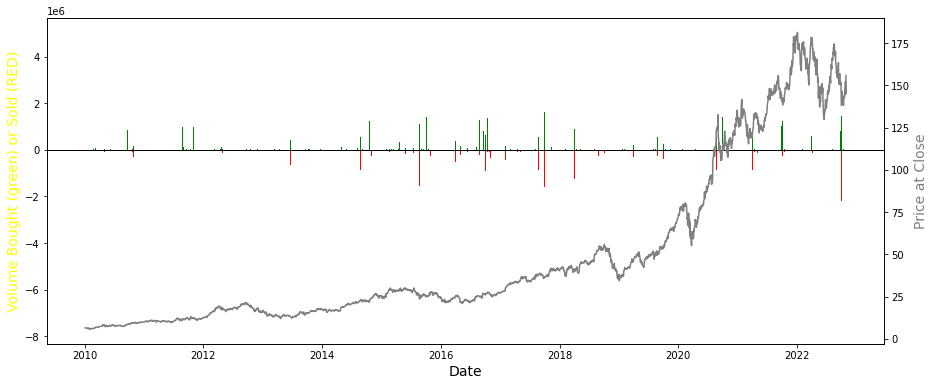

Displaying data for MSFT over specified time period.


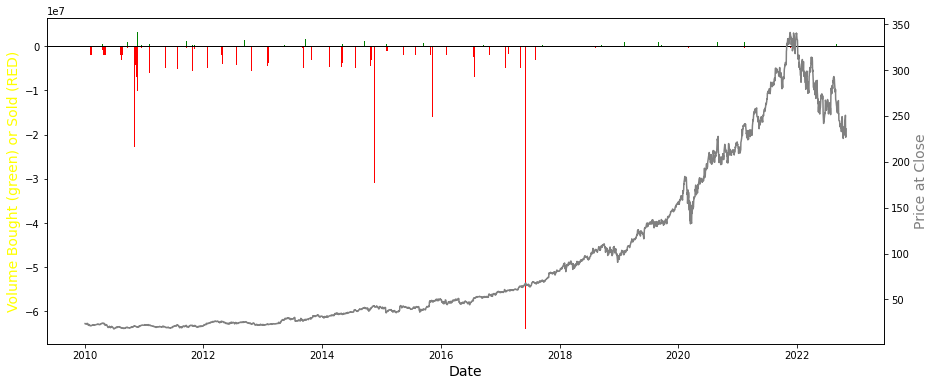

Displaying data for AMZN over specified time period.


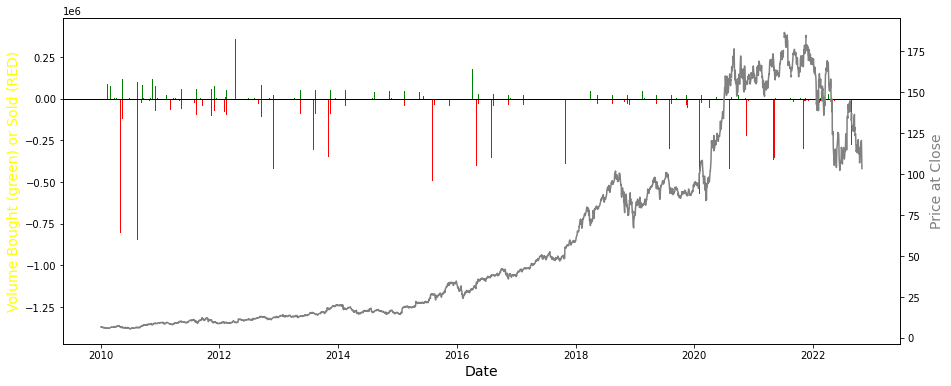

Displaying data for TSLA over specified time period.


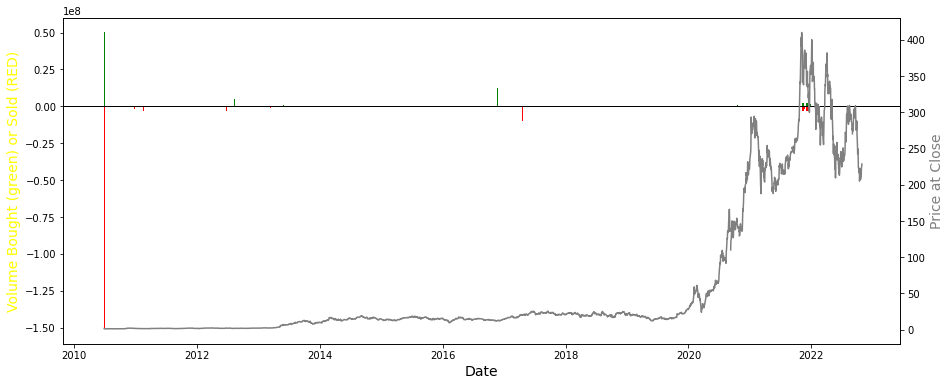

Displaying data for GOOGL over specified time period.


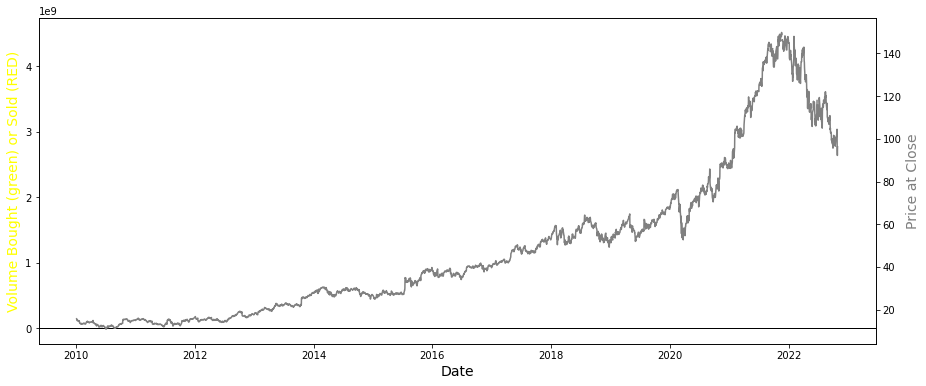

Displaying data for UNH over specified time period.


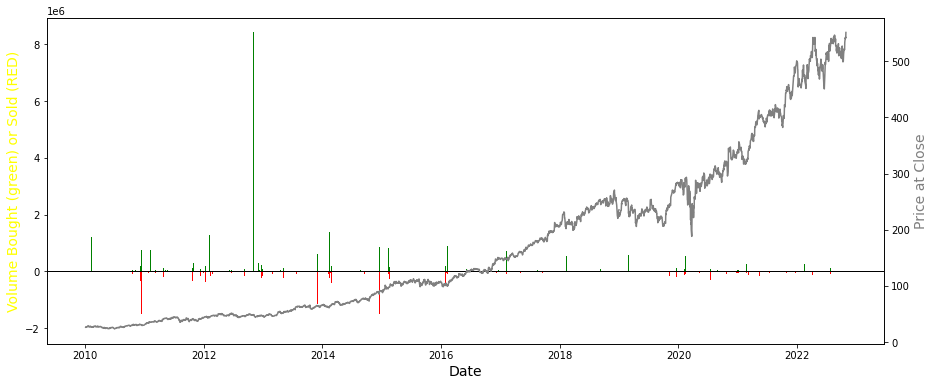

Displaying data for GOOG over specified time period.


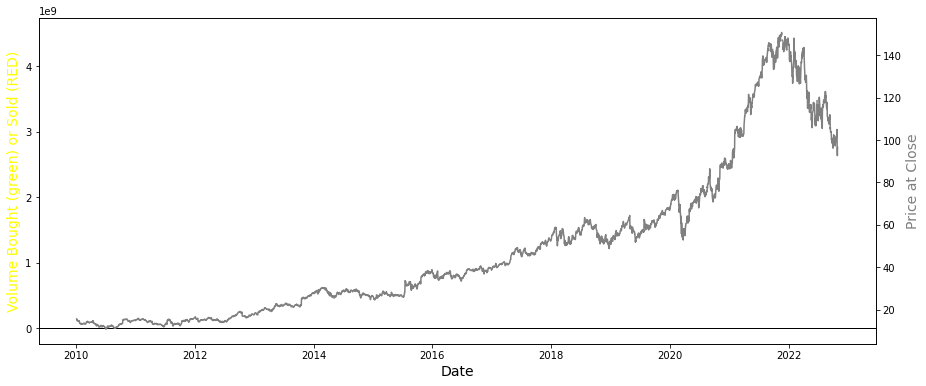

Displaying data for JNJ over specified time period.


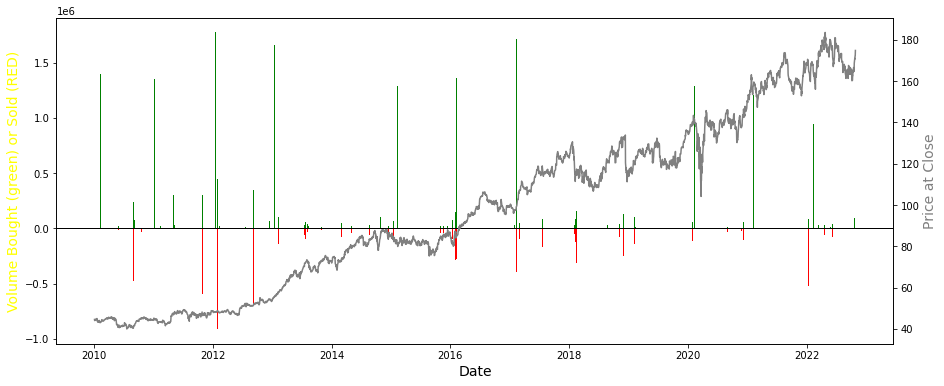

Displaying data for XOM over specified time period.


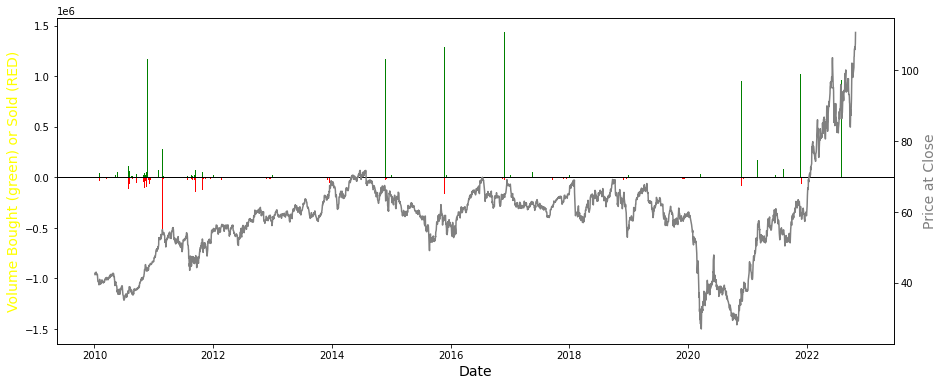

Displaying data for JPM over specified time period.


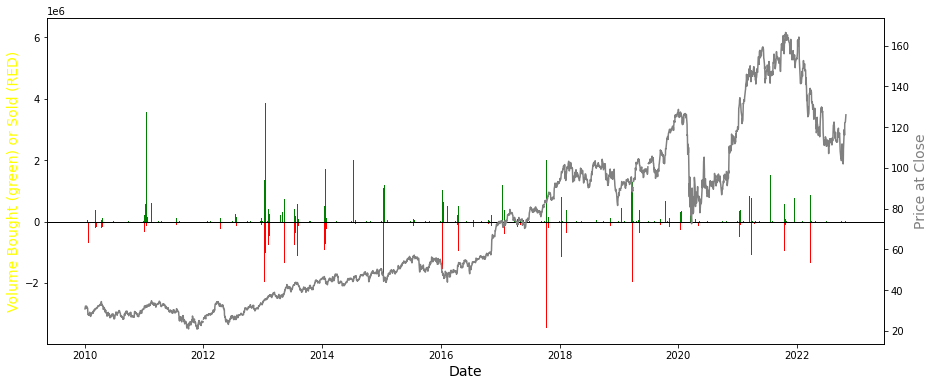

In [24]:
import pandas_datareader as web
import datetime
from matplotlib import pyplot as plt
import pandas as pd
import psycopg
import warnings

def load_rel_data(startDate, endDate, stockSymbol):
    # Get insider trading info from the database.
    warnings.filterwarnings("ignore")
    with psycopg.connect("host='{}' port={} dbname='{}' user={} password={}"
                         .format("127.0.0.1", "5432", "insider_trading", "ethan", "ethan")) as conn:
        sql_D = "SELECT transaction_date, number_of_securities_transacted FROM insiders WHERE company = '{}' AND acquistion_or_disposition = 'D';".format(stockSymbol)
        sql_A = "SELECT transaction_date, number_of_securities_transacted FROM insiders WHERE company = '{}' AND acquistion_or_disposition = 'A';".format(stockSymbol)
        
        dat_D = pd.read_sql_query(sql_D, conn)
        dat_A = pd.read_sql_query(sql_A, conn)
        
    # Change types to datetime and float to make the graphs work.
    dat_D['transaction_date'] = pd.to_datetime(dat_D['transaction_date'], format='%Y-%m-%d')
    dat_D = dat_D.astype({'number_of_securities_transacted':'float'})
    
    dat_A['transaction_date'] = pd.to_datetime(dat_A['transaction_date'], format='%Y-%m-%d')
    dat_A = dat_A.astype({'number_of_securities_transacted':'float'})

    # Sum everything that has the same transaction date. 
    # It may be the case that you have two large sell orders from different insiders.
    dat_D = dat_D.groupby('transaction_date').sum()
    dat_A = dat_A.groupby('transaction_date').sum()
    
    # Rename columns before zipping together.
    dat_D = dat_D.rename(columns={'number_of_securities_transacted': 'VolumeSold'})
    dat_A = dat_A.rename(columns={'number_of_securities_transacted': 'VolumeBought'})

    # Read from the web.
    df = web.DataReader(stockSymbol, 'yahoo', startDate, endDate)

    # Trim the stuff we don't care about.
    trimmed = df.drop(df.columns[[0,1,2,3]], axis=1)

    # Zip together volume, insider-sold securities, and close price of a stock.
    concatdat = pd.concat([trimmed, dat_D, dat_A], axis=1)
    
    # Rename the columns of the dataframe so they can be called easier.
    concatdat = concatdat.rename(columns={'Adj Close': 'ClosePrice'})
    
    # Set and rename the index.
    concatdat.index.names = ["Date"]
    concatdat = concatdat.reset_index()
    
    # Trim the dataset to the specified size.
    mask = (concatdat["Date"] > startDate) & (concatdat["Date"] <= endDate)
    concatdat = concatdat.loc[mask]
    
    return concatdat

def graph_sold_price(concatdat):
    # Create a figure object that we can store three plots in.
    fig,volume = plt.subplots(figsize=(15,6))
    
    # Volume sold will be shown as red, volume bought will be sold as green.
    volume.bar(concatdat.Date, concatdat.VolumeSold*-1, color="red", width=3)
    volume.bar(concatdat.Date, concatdat.VolumeBought, color="green", width=4)
    
    # Set axis label info.
    volume.set_xlabel("Date", fontsize = 14)
    volume.set_ylabel("Volume Bought (green) or Sold (RED)", color="yellow", fontsize=14)
    
    # Create a black line to draw sharp distinction between sold and bought volume.
    volume.axhline(y=0, color= 'black', linewidth=1,)
    
    # Use twinx() to add another plot with a different y-axis.
    price=volume.twinx()
    price.plot(concatdat.Date, concatdat.ClosePrice, color="grey")
    price.set_ylabel("Price at Close", color="grey", fontsize=14)
    
    # Display the plot.
    plt.show()

if __name__ == "__main__":
    # Define the region of time over which you are interested.
    start = datetime.datetime(2010, 1, 1)
    end = datetime.datetime(2022, 10, 29)
    
    # Iterate over all stock listed in sandp10.yaml.
    for stock in stocks:
        print("Displaying data for " + stocks[stock].get("symbol") + " over specified time period.")
        data = load_rel_data(start, end, stocks[stock].get("symbol"))
        graph_sold_price(data)